What is the agent learning? Well just the identity map... It's pretty straightforward, since it's a delta.


If we put as state the note played before, and the target is to learn the next note to play

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
    

In [22]:
class Evaluator():
    def __init__(self):
        self.reward_history = []
        self.trajectories = []
        self.trajectories_eval = []
        self.qtables=[]
    def give_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
        
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01):
        self.n_actions = notes_to_choose
        self.states = notes_to_choose
        self.q = np.ones((notes_to_choose, notes_to_choose))
        self.n = np.ones((notes_to_choose, notes_to_choose))
        
        self.epsilon = ep
        self.gamma = gamma
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]
            

    def q_learn(self, ts):
        ### q-learn
        for interaction in ts:
            s, a, r, ns = interaction
            self.n[s,a]+=1
            self.q[s,a] += (r- self.q[s,a])/self.n[s,a]
            
            #if ns != -1:
            #    self.n[s,a]+=1
            #    self.q[s,a] += (r + self.gamma*np.max(self.q[ns,:]) - self.q[s,a])/self.n[s,a]
            #else:
            #    self.n[s,a]+=1
            #    self.q[s,a] += (r- self.q[s,a])/self.n[s,a]
                
    def decrease_ep(self,ind, tau=500):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/tau), 0.01)
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player

100%|██████████| 100/100 [00:00<00:00, 2037.84it/s]


Text(0.5, 1.0, 'Learning curve')

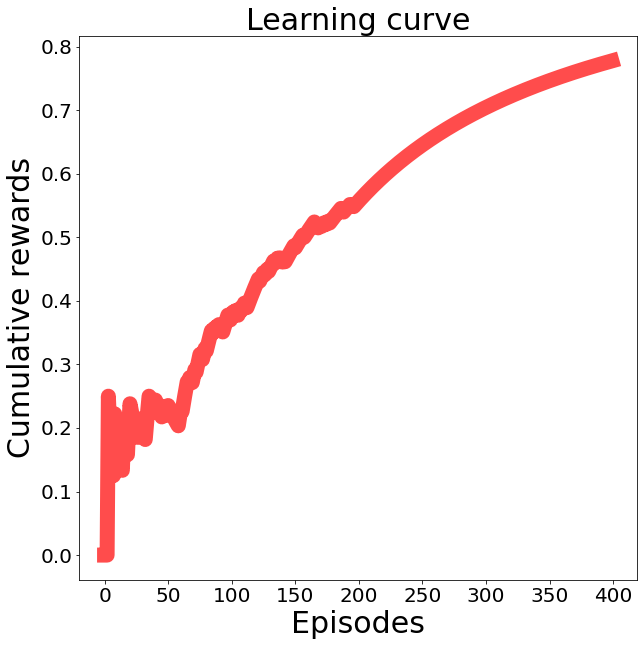

In [23]:
evaluator = Evaluator()
agent = Agent(4, gamma=0., ep=1)
episode_evaluate = [0,1,2,3,10,20,30] 
melody = [3,1,2,0] 

for episode in tqdm(range(10**2)):
    evaluator.qtables.append(agent.q.copy())
    
    ts=[]
    actions=[]
    state = melody[0]
    for ind,note in zip(range(1,len(melody)+2), melody[1:] + melody[0:1]):
        action = agent.give_action(state)
        actions.append(action)
        reward = evaluator.give_reward(action,note)
        evaluator.reward_history.append(reward)
        next_state = melody[ind%len(melody)]
        ts.append([state, action, reward, next_state])
        state = next_state ### Transition rule!
        
    agent.q_learn(ts)
    agent.decrease_ep(episode)
    evaluator.trajectories.append(actions)
    
    if episode in episode_evaluate:
        evaluator.trajectories_eval.append(agent.give_melody(melody))
        evaluator.trajectories.append(actions)
        
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=15, alpha=0.7,color="red")
plt.xlabel("Episodes",size=30)
plt.ylabel("Cumulative rewards", size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Learning curve", size=30)

100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


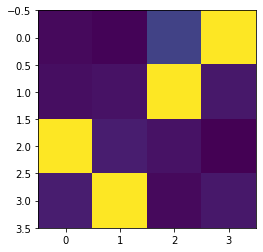

In [4]:
import os
os.makedirs("qtables_fig", exist_ok=True)
tot_plots=0
for ind,k in enumerate(tqdm(evaluator.qtables[:50])):
    plt.imshow(k)
    plt.savefig("qtables_fig/{}.png".format(ind))
    tot_plots+=1

In [7]:
with open("qtables_fig/ordershort.txt","w") as f:
    for k in range(tot_plots):#len(evaluator.qtables)):
        f.write("{}.png\n".format(k))
f.close()

os.system("cd qtables_fig; convert -delay 0.1 @ordershort.txt -loop 0 qtab.gif")

0

In [10]:
import pandas as pd
os.makedirs("dataTrain", exist_ok=True)
ind=0
dd = pd.DataFrame.from_dict({evaluator.trajectories[ind]}, orient="index")
dd.to_csv("dataTrain".format(ind), header=False)

TypeError: unhashable type: 'list'

In [20]:
np.savetxt("dataTrain/0.csv",np.array(evaluator.trajectories[0:1]).astype(int), fmt='%i', delimiter=",")

In [ ]:


with open("dataTrain/ordershort.txt","w") as f:
    for k in range(tot_plots):#len(evaluator.qtables)):
        f.write("{}.png\n".format(k))
f.close()

os.system("cd qtables_fig; convert -delay 0.1 @ordershort.txt -loop 0 qtab.gif")